**Resources Used:**
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pltlab

from PIL import Image

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# MNIST dataset
batch_size = 32
def datasetDef(batch_size):
#     transform = transforms.Compose([
#     transforms.Resize((128, 128)),  # Resize to 128x128
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
# ])
    train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=True,
                                            transform=transforms.ToTensor(),
                                            download=True)

    test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False,
                                            transform=transforms.ToTensor())

    # Data loader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)
    return train_dataset, test_dataset, train_loader, test_loader

train_dataset, test_dataset, train_loader, test_loader = datasetDef(batch_size)

classList = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

100%|██████████| 170M/170M [00:07<00:00, 21.8MB/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data/


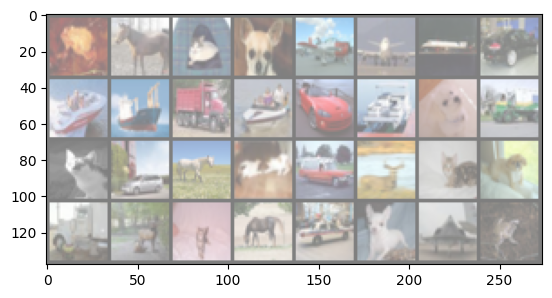

frog  horse cat   dog   plane plane plane car   ship  ship  truck ship  car   ship  dog   truck cat   car   horse cat   car   deer  cat   dog   truck deer  cat   horse car   dog   plane frog 


In [ ]:
#function taken from the resource listed above

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classList[labels[j]]:5s}' for j in range(batch_size)))

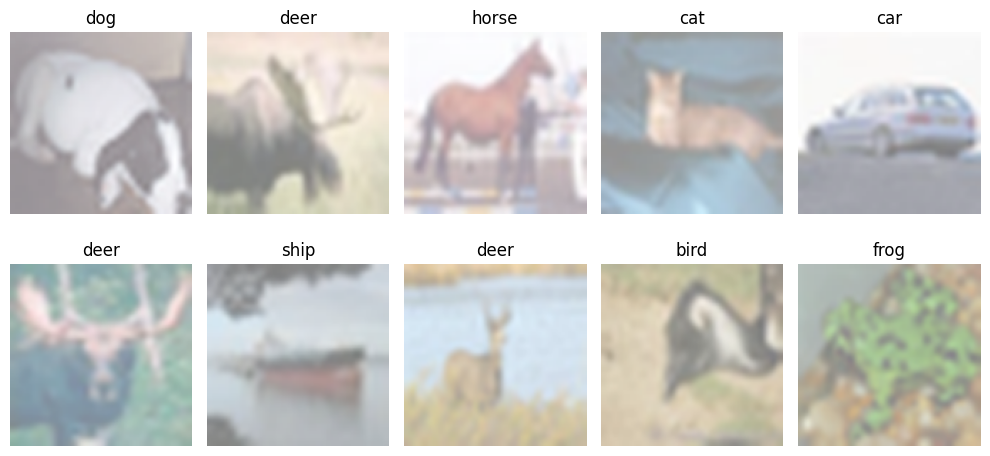

In [ ]:
# Function to resize an image to higher resolution
def resize_image(image_tensor, size=(128, 128)):
    # Convert tensor to PIL Image, denormalize it for visualization
    image = image_tensor.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Rescale from [-1, 1] to [0, 1]
    pil_image = Image.fromarray((image * 255).astype(np.uint8))  # Convert to uint8
    resized_image = pil_image.resize(size, Image.Resampling.LANCZOS)
    return np.array(resized_image)

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Resize images and prepare for visualization
resized_images = [resize_image(img) for img in images]

# Visualize resized images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(resized_images[i])
    plt.title(classList[labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Hyper-parameters
input_size = 32768. #32x32x3(RGB)
hidden_size = 500
num_classes = 10
num_epochs = 20
batch_size = 50
learning_rate = 0.01

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Layer 1: Convolutional layer with 10 filters, 5x5 kernel, stride=1, padding=2
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Layer 2: Convolutional layer with 20 filters, 5x5 kernel, stride=1, padding=2
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Layer 3: Fully connected layer with 50 neurons
        self.fc1 = nn.Linear(in_features=20 * 8 * 8, out_features=50)

        # Layer 4: Fully connected layer with 10 neurons
        self.fc2 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))

        x = self.pool2(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))

        x = self.fc2(x)

        return x


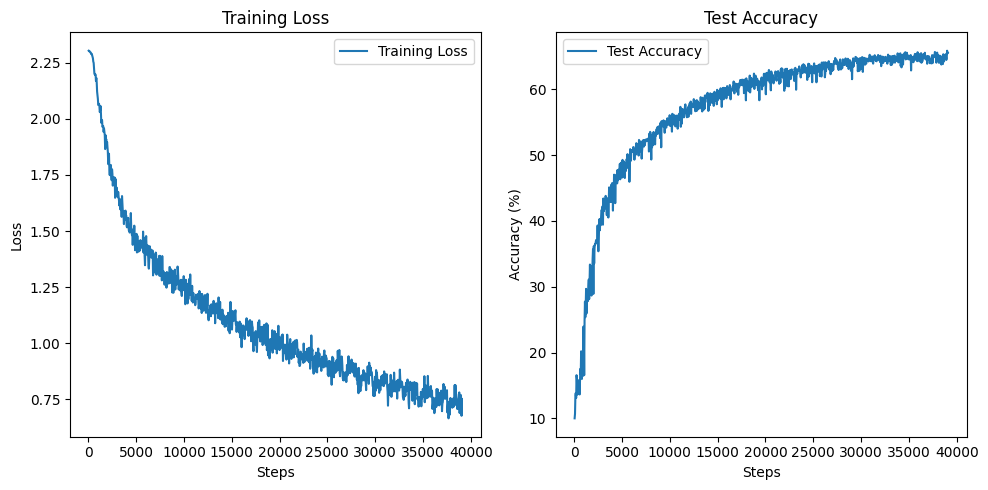

In [ ]:
# Initialize model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
training_losses = []
test_accuracies = []
steps = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 1):  # Start index from 1
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store training loss and test accuracy every 2000 images
        if i % 40 == 0:  # 40 minibatches of 50 = 2000 images
            steps.append(epoch * len(train_loader) + i)
            training_losses.append(running_loss / 40)  # Average loss
            running_loss = 0.0

            # Evaluate test accuracy
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for test_images, test_labels in test_loader:
                    test_outputs = model(test_images)
                    _, predicted = torch.max(test_outputs.data, 1)
                    total += test_labels.size(0)
                    correct += (predicted == test_labels).sum().item()
            accuracy = 100 * correct / total
            test_accuracies.append(accuracy)
            model.train()

# Plot training loss and test accuracy
plt.figure(figsize=(10, 5))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(steps, training_losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(steps, test_accuracies, label="Test Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

PERFORMING SVD ON DATASET TO SEE ACCURACY

Files already downloaded and verified
Shape of U: torch.Size([50000, 28])
Shape of S: torch.Size([28, 28])
Shape of Vt: torch.Size([28, 3072])
Shape of Reconstructed image:  torch.Size([50000, 3072])


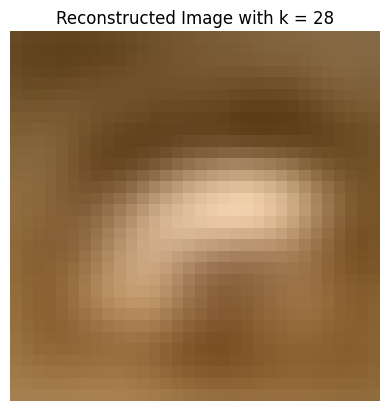

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# 1. Load and preprocess the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL images to tensors
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)

# Extract the entire dataset as a single batch
images, _ = next(iter(trainloader))

# 2. Flatten the images to create a 2D matrix
# CIFAR-10 images are 32x32x3; flatten to 3072 for each image
images_flattened = images.view(images.size(0), -1)

# 3. Perform SVD
# Compute SVD: A = U @ S @ V.T
U, S, Vt = torch.linalg.svd(images_flattened, full_matrices=False)
U_reduced = U[:, :28]
S_reduced = torch.diag(S[:28])
Vt_reduced = Vt[:28, :]
reconstructed_images = U_reduced @ S_reduced @ Vt_reduced

# Print shapes of the matrices
print("Shape of U:", U_reduced.shape)  # (num_samples, num_samples)
print("Shape of S:", S_reduced.shape)  # (min(num_samples, num_features))
print("Shape of Vt:", Vt_reduced.shape)  # (num_features, num_features)
print("Shape of Reconstructed image: ",reconstructed_images.shape)

reconstructed_images = reconstructed_images.view(-1, 3, 32, 32)  # Convert back to original dimensions


\

# Select one reconstructed image and convert it to NumPy
reconstructed_image = reconstructed_images[0].permute(1, 2, 0).numpy()

print("Min value:", reconstructed_images.min().item())
print("Max value:", reconstructed_images.max().item())

# Display the image
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image with k = 28")
plt.axis("off")
plt.show()






In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Layer 1: Convolutional layer with 10 filters, 5x5 kernel, stride=1, padding=2
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Layer 2: Convolutional layer with 20 filters, 5x5 kernel, stride=1, padding=2
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Layer 3: Fully connected layer with 50 neurons
        self.fc1 = nn.Linear(in_features=20 * 7 * 7, out_features=50)  # Adjust input size based on image dimensions after pooling

        # Layer 4: Fully connected layer with 10 neurons
        self.fc2 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))

        x = self.pool2(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)  # Flatten all dimensions except batch

        x = F.relu(self.fc1(x))

        # Apply second fully connected layer
        x = self.fc2(x)

        return x

TRAINING MODEL AGAIN AFTER SVD

In [ ]:
# Initialize model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
training_losses = []
test_accuracies = []
steps = []



for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 1):  # Start index from 1
        # Forward pass
        images = reconstructed_images.view(-1, 3, 32, 32)

        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store training loss and test accuracy every 2000 images
        if i % 40 == 0:  # 40 minibatches of 50 = 2000 images
            steps.append(epoch * len(train_loader) + i)
            training_losses.append(running_loss / 40)  # Average loss
            running_loss = 0.0

            # Evaluate test accuracy
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for test_images, test_labels in test_loader:
                    test_outputs = model(test_images)
                    _, predicted = torch.max(test_outputs.data, 1)
                    total += test_labels.size(0)
                    correct += (predicted == test_labels).sum().item()
            accuracy = 100 * correct / total
            test_accuracies.append(accuracy)
            model.train()

# Plot training loss and test accuracy
plt.figure(figsize=(10, 5))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(steps, training_losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(steps, test_accuracies, label="Test Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x32 and 3x3)

In [ ]:
ranks = range(1, 32, 5)  # Test rank values from 1 to 100, in steps of 5

for rank in ranks:
    # Use only the top `rank` singular values
    U_reduced = U[:, :rank]
    S_reduced = torch.diag(S[:rank])
    Vt_reduced = Vt[:rank, :]
    reconstructed_images = (U @ torch.diag(S) @ Vt)


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 1. Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)
test_loader = DataLoader(testset, batch_size=len(testset), shuffle=False)

# Load all training images into memory
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

# 2. Flatten images for SVD
train_images_flattened = train_images.view(train_images.size(0), -1)  # (50000, 3072)
test_images_flattened = test_images.view(test_images.size(0), -1)    # (10000, 3072)

# 3. Apply SVD
# Compute SVD for training data
U, S, Vt = torch.linalg.svd(train_images_flattened, full_matrices=False)

# Reduce dimensionality: retain top-k components
k = 28  # Number of singular values to retain
U_reduced = U[:, :k]
S_reduced = S[:k]
Vt_reduced = Vt[:k, :]

# Reconstruct training and test images with reduced dimensions
reconstructed_train_images = torch.mm(U_reduced, torch.diag(S_reduced)) @ Vt_reduced
# Project the test images into the reduced dimensional space using the same basis (Vt_reduced) as the training data
test_images_reduced = torch.mm(test_images_flattened, Vt_reduced.T)
# Reconstruct the test images using the reduced basis and the training data's transformation
reconstructed_test_images = torch.mm(test_images_reduced, Vt_reduced)

# 4. Reshape back to original dimensions for CNN
reconstructed_train_images = reconstructed_train_images.view(-1, 3, 32, 32)
reconstructed_test_images = reconstructed_test_images.view(-1, 3, 32, 32)

# Check shapes
print("Reconstructed train images shape:", reconstructed_train_images.shape)  # (50000, 3, 32, 32)
print("Reconstructed test images shape:", reconstructed_test_images.shape)    # (10000, 3, 32, 32)


SVD WITH RANK OF 24

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to Apply SVD with Rank 24
def svd_compression(images, rank=24):
    compressed_images = []
    for img in images:
        img_np = img.permute(1, 2, 0).numpy()  # Convert to HxWxC
        compressed_img = np.zeros_like(img_np)
        for c in range(3):  # Loop over RGB channels
            u, s, vh = np.linalg.svd(img_np[:, :, c], full_matrices=False)
            compressed_img[:, :, c] = (u[:, :rank] @ np.diag(s[:rank]) @ vh[:rank, :])
        compressed_images.append(torch.tensor(compressed_img).permute(2, 0, 1))  # Back to CxHxW
    return torch.stack(compressed_images)

# Custom Dataset for SVD-Compressed Images
class SVDDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, rank=24):
        self.dataset = dataset
        self.rank = rank

    def __getitem__(self, index):
        img, label = self.dataset[index]
        img_svd = svd_compression(img.unsqueeze(0), rank=self.rank)[0]
        return img_svd, label

    def __len__(self):
        return len(self.dataset)

svd_train_dataset = SVDDataset(train_dataset, rank=24)
svd_train_loader = torch.utils.data.DataLoader(svd_train_dataset, batch_size=64, shuffle=True)

# Define the CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=20 * 8 * 8, out_features=50)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training Code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in svd_train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(svd_train_loader):.4f}")

print("Training completed.")

# Evaluate on Test Set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")


100%|██████████| 170M/170M [00:04<00:00, 35.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/20], Loss: 1.5201
Epoch [2/20], Loss: 1.2134
Epoch [3/20], Loss: 1.0810
Epoch [4/20], Loss: 0.9870
Epoch [5/20], Loss: 0.9207
Epoch [6/20], Loss: 0.8727
Epoch [7/20], Loss: 0.8313
Epoch [8/20], Loss: 0.7968
Epoch [9/20], Loss: 0.7618
Epoch [10/20], Loss: 0.7335
Epoch [11/20], Loss: 0.7060
Epoch [12/20], Loss: 0.6809
Epoch [13/20], Loss: 0.6596
Epoch [14/20], Loss: 0.6363
Epoch [15/20], Loss: 0.6183
Epoch [16/20], Loss: 0.5972
Epoch [17/20], Loss: 0.5780
Epoch [18/20], Loss: 0.5640
Epoch [19/20], Loss: 0.5446
Epoch [20/20], Loss: 0.5332
Training completed.
Accuracy on test set: 66.91%


SVD with rank 26

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to Apply SVD with Rank 26
def svd_compression(images, rank=26):
    compressed_images = []
    for img in images:
        img_np = img.permute(1, 2, 0).numpy()  # Convert to HxWxC
        compressed_img = np.zeros_like(img_np)
        for c in range(3):  # Loop over RGB channels
            u, s, vh = np.linalg.svd(img_np[:, :, c], full_matrices=False)
            compressed_img[:, :, c] = (u[:, :rank] @ np.diag(s[:rank]) @ vh[:rank, :])
        compressed_images.append(torch.tensor(compressed_img).permute(2, 0, 1))  # Back to CxHxW
    return torch.stack(compressed_images)

# Custom Dataset for SVD-Compressed Images
class SVDDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, rank=26):
        self.dataset = dataset
        self.rank = rank

    def __getitem__(self, index):
        img, label = self.dataset[index]
        img_svd = svd_compression(img.unsqueeze(0), rank=self.rank)[0]
        return img_svd, label

    def __len__(self):
        return len(self.dataset)

svd_train_dataset = SVDDataset(train_dataset, rank=26)
svd_train_loader = torch.utils.data.DataLoader(svd_train_dataset, batch_size=64, shuffle=True)

# Define the CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=20 * 8 * 8, out_features=50)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training Code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in svd_train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(svd_train_loader):.4f}")

print("Training completed.")

# Evaluate on Test Set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")


100%|██████████| 170M/170M [00:04<00:00, 41.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/20], Loss: 1.5630
Epoch [2/20], Loss: 1.2418
Epoch [3/20], Loss: 1.1115
Epoch [4/20], Loss: 1.0221
Epoch [5/20], Loss: 0.9592
Epoch [6/20], Loss: 0.9086
Epoch [7/20], Loss: 0.8650
Epoch [8/20], Loss: 0.8294
Epoch [9/20], Loss: 0.8002
Epoch [10/20], Loss: 0.7716
Epoch [11/20], Loss: 0.7508
Epoch [12/20], Loss: 0.7247
Epoch [13/20], Loss: 0.7067
Epoch [14/20], Loss: 0.6861
Epoch [15/20], Loss: 0.6671
Epoch [16/20], Loss: 0.6499
Epoch [17/20], Loss: 0.6355
Epoch [18/20], Loss: 0.6220
Epoch [19/20], Loss: 0.6072
Epoch [20/20], Loss: 0.5931
Training completed.
Accuracy on test set: 67.79%


Files already downloaded and verified
Files already downloaded and verified
Training and Evaluating for rank: 32
Epoch [1/20], Loss: 1.5102
Epoch [2/20], Loss: 1.1998
Epoch [3/20], Loss: 1.0599
Epoch [4/20], Loss: 0.9821
Epoch [5/20], Loss: 0.9216
Epoch [6/20], Loss: 0.8687
Epoch [7/20], Loss: 0.8302
Epoch [8/20], Loss: 0.8003
Epoch [9/20], Loss: 0.7636
Epoch [10/20], Loss: 0.7355
Epoch [11/20], Loss: 0.7092
Epoch [12/20], Loss: 0.6881
Epoch [13/20], Loss: 0.6595
Epoch [14/20], Loss: 0.6420
Epoch [15/20], Loss: 0.6209
Epoch [16/20], Loss: 0.6051
Epoch [17/20], Loss: 0.5841
Epoch [18/20], Loss: 0.5695
Epoch [19/20], Loss: 0.5494
Epoch [20/20], Loss: 0.5347
Training completed.
Class: plane, Accuracy: 69.80%
Class: car, Accuracy: 80.50%
Class: bird, Accuracy: 57.20%
Class: cat, Accuracy: 53.10%
Class: deer, Accuracy: 50.70%
Class: dog, Accuracy: 55.10%
Class: frog, Accuracy: 79.70%
Class: horse, Accuracy: 67.90%
Class: ship, Accuracy: 84.50%
Class: truck, Accuracy: 72.00%
Rank: 32, Accura

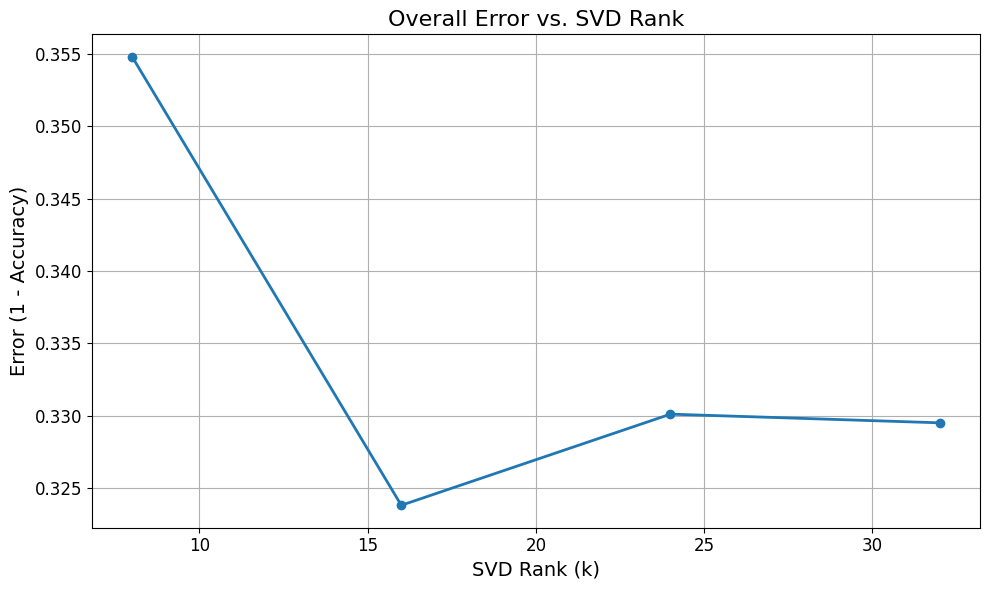

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to Apply SVD with Rank 18
def svd_compression(images, rank=rank):
    compressed_images = []
    for img in images:
        img_np = img.permute(1, 2, 0).numpy()  # Convert to HxWxC
        compressed_img = np.zeros_like(img_np)
        for c in range(3):  # Loop over RGB channels
            u, s, vh = np.linalg.svd(img_np[:, :, c], full_matrices=False)
            compressed_img[:, :, c] = (u[:, :rank] @ np.diag(s[:rank]) @ vh[:rank, :])
        compressed_images.append(torch.tensor(compressed_img).permute(2, 0, 1))  # Back to CxHxW
    return torch.stack(compressed_images)

# Custom Dataset for SVD-Compressed Images with Rank 18
class SVDDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, rank=rank):  # Adjusted rank to 18
        self.dataset = dataset
        self.rank = rank

    def __getitem__(self, index):
        img, label = self.dataset[index]
        img_svd = svd_compression(img.unsqueeze(0), rank=self.rank)[0]
        return img_svd, label

    def __len__(self):
        return len(self.dataset)


# svd_train_dataset = SVDDataset(train_dataset, rank=18)  # Adjusted rank to 18
# svd_train_loader = torch.utils.data.DataLoader(svd_train_dataset, batch_size=64, shuffle=True)

# Define the CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=20 * 8 * 8, out_features=50)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training Code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SimpleCNN().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 20

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, labels in svd_train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images.float())
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(svd_train_loader):.4f}")

# print("Training completed.")

# Evaluate the Model for Different Ranks
ranks = range(32, 1, -8)  # Range of ranks
errors = []  # To store errors for each rank

for rank in ranks:
    print(f"Training and Evaluating for rank: {rank}")
    svd_train_dataset = SVDDataset(train_dataset, rank=rank)
    svd_train_loader = torch.utils.data.DataLoader(svd_train_dataset, batch_size=64, shuffle=True)
    svd_test_dataset = SVDDataset(test_dataset, rank=rank)
    svd_test_loader = torch.utils.data.DataLoader(svd_test_dataset, batch_size=64, shuffle=False)

    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 20

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in svd_train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(svd_train_loader):.4f}")

    print("Training completed.")

    # Evaluate on Test Set
    model.eval()
    correct = [0] * 10
    total = [0] * 10
    with torch.no_grad():
        for images, labels in svd_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for label, prediction in zip(labels, predicted):
                total[label.item()] += 1
                if label == prediction:
                    correct[label.item()] += 1
    # Print accuracy for each class
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
              'dog', 'frog', 'horse', 'ship', 'truck')

    for i in range(10):
        accuracy = 100 * correct[i] / total[i] if total[i] > 0 else 0
        print(f"Class: {classes[i]}, Accuracy: {accuracy:.2f}%")

    # Compute overall accuracy and error
    overall_correct = sum(correct)
    overall_total = sum(total)
    overall_accuracy = overall_correct / overall_total if overall_total > 0 else 0
    overall_error = 1 - overall_accuracy
    errors.append(overall_error)
    print(f"Rank: {rank}, Accuracy: {overall_accuracy:.4f}, Error: {overall_error:.4f}")

# Plot Errors for All Ranks
plt.figure(figsize=(10, 6))
plt.plot(ranks, errors, marker='o', linestyle='-', linewidth=2)
plt.title('Overall Error vs. SVD Rank', fontsize=16)
plt.xlabel('SVD Rank (k)', fontsize=14)
plt.ylabel('Error (1 - Accuracy)', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

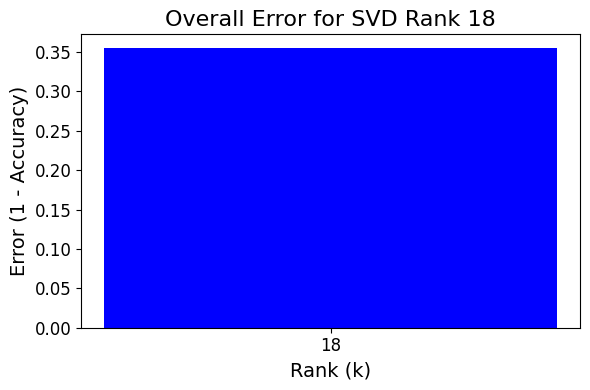

In [ ]:
overall_correct = sum(correct)
overall_total = sum(total)
overall_accuracy = overall_correct / overall_total if overall_total > 0 else 0
overall_error = 1 - overall_accuracy
plt.figure(figsize=(6, 4))
plt.bar([18], [overall_error], color='blue', width=1.0)  # Rank is 18
plt.title('Overall Error for SVD Rank 18', fontsize=16)
plt.xlabel('Rank (k)', fontsize=14)
plt.ylabel('Error (1 - Accuracy)', fontsize=14)
plt.xticks([18], fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(ranks, errors, marker='o', linestyle='-', linewidth=2)
plt.title('Overall Error vs. SVD Rank', fontsize=16)
plt.xlabel('SVD Rank (k)', fontsize=14)
plt.ylabel('Error (1 - Accuracy)', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


NameError: name 'ranks' is not defined

<Figure size 1000x600 with 0 Axes>

Rank Decrease Loop

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to Apply SVD with Rank 18
def svd_compression(images, rank):
    compressed_images = []
    for img in images:
        img_np = img.permute(1, 2, 0).numpy()  # Convert to HxWxC
        compressed_img = np.zeros_like(img_np)
        for c in range(3):  # Loop over RGB channels
            u, s, vh = np.linalg.svd(img_np[:, :, c], full_matrices=False)
            compressed_img[:, :, c] = (u[:, :rank] @ np.diag(s[:rank]) @ vh[:rank, :])
        compressed_images.append(torch.tensor(compressed_img).permute(2, 0, 1))  # Back to CxHxW
    return torch.stack(compressed_images)

# Custom Dataset for SVD-Compressed Images with Rank 18
class SVDDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, rank):  # Adjusted rank to 18
        self.dataset = dataset
        self.rank = rank

    def __getitem__(self, index):
        img, label = self.dataset[index]
        img_svd = svd_compression(img.unsqueeze(0), rank=self.rank)[0]
        return img_svd, label

    def __len__(self):
        return len(self.dataset)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(in_features=20 * 8 * 8, out_features=50)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

arrayK = []
ranks = range(32,1, -4)

for k in ranks:
    print("The current Rank is:", k)
    svd_train_dataset = SVDDataset(train_dataset, k)  # Adjusted rank to k
    svd_train_loader = torch.utils.data.DataLoader(svd_train_dataset, batch_size=64, shuffle=True)

    # Training Code
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Model().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 20

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in svd_train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(svd_train_loader):.4f}")

    print("Training completed.")

    torch.save(model.state_dict(), f"modelSVDrank_{k}.pth")
    # Evaluate on Test Set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    arrayK.append(accuracy)

    print(f"Accuracy on test set: {100 * correct / total:.2f}%")

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
The current Rank is: 32
Epoch [1/20], Loss: 1.5312
Epoch [2/20], Loss: 1.2019
Epoch [3/20], Loss: 1.0615
Epoch [4/20], Loss: 0.9728
Epoch [5/20], Loss: 0.9136
Epoch [6/20], Loss: 0.8663
Epoch [7/20], Loss: 0.8226
Epoch [8/20], Loss: 0.7886
Epoch [9/20], Loss: 0.7607
Epoch [10/20], Loss: 0.7343
Epoch [11/20], Loss: 0.7074
Epoch [12/20], Loss: 0.6870
Epoch [13/20], Loss: 0.6650
Epoch [14/20], Loss: 0.6476
Epoch [15/20], Loss: 0.6231
Epoch [16/20], Loss: 0.6032
Epoch [17/20], Loss: 0.5850
Epoch [18/20], Loss: 0.5685
Epoch [19/20], Loss: 0.5536
Epoch [20/20], Loss: 0.5372
Training completed.
Accuracy on test set: 67.65%
The current Rank is: 28
Epoch [1/20], Loss: 1.5639
Epoch [2/20], Loss: 1.2262
Epoch [3/20], Loss: 1.0894
Epoch [4/20], Loss: 1.0075
Epoch [5/20], Loss: 0.9451
Epoch [6/20], Loss: 0.9011
Epoch [7/20], Loss: 0.8632
Epoch [8/20], Loss: 0.8312
Epoch [9/20], Loss: 0.8057
Epoch [10/20], Loss:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to Apply SVD with Rank 18
def svd_compression(images, rank):
    compressed_images = []
    for img in images:
        img_np = img.permute(1, 2, 0).numpy()  # Convert to HxWxC
        compressed_img = np.zeros_like(img_np)
        for c in range(3):  # Loop over RGB channels
            u, s, vh = np.linalg.svd(img_np[:, :, c], full_matrices=False)
            compressed_img[:, :, c] = (u[:, :rank] @ np.diag(s[:rank]) @ vh[:rank, :])
        compressed_images.append(torch.tensor(compressed_img).permute(2, 0, 1))  # Back to CxHxW
    return torch.stack(compressed_images)
s
# Custom Dataset for SVD-Compressed Images with Rank 18
class SVDDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, rank):  # Adjusted rank to 18
        self.dataset = dataset
        self.rank = rank

    def __getitem__(self, index):
        img, label = self.dataset[index]
        img_svd = svd_compression(img.unsqueeze(0), rank=self.rank)[0]
        return img_svd, label

    def __len__(self):
        return len(self.dataset)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(in_features=30 * 4 * 4, out_features=100)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(in_features=100,out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=10)


    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

arrayK = []
ranks = range(32,1, -4)
lowest_rank = 20
train_loss = []
train_acc = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

for k in ranks:
    print("Starting training for rank ", k)
    train_lossPerRank = []
    train_accPerRank = []
    svd_train_dataset = SVDDataset(train_dataset, k)  # Adjusted rank to k
    svd_train_loader = torch.utils.data.DataLoader(svd_train_dataset, batch_size=64, shuffle=True)
    svd_test_dataset = SVDDataset(test_dataset, k)  # Adjusted rank to k
    svd_test_loader = torch.utils.data.DataLoader(svd_test_dataset, batch_size=64, shuffle=True)

    # Training Code

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(svd_train_loader, 1):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if ((i + 1) % 40) == 0: #takes the training loss every 40 batches
            # Storing training loss
                train_loss.append(loss.item())
            # Store test acc
                acc = labels == outputs.argmax(1).sum() / labels.shape[0] * 100
                acc = acc.to(cpu)
                train_acc.append(acc)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(svd_train_loader):.4f}")
    train_lossPerRank.append(train_loss)
    train_accPerRank.append(train_acc)
    print("Rank ", k, " training has been finished.")

    torch.save(model.state_dict(), f"modelSVDrank_{k}.pth")
    # Evaluate on Test Set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in svd_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    arrayK.append(accuracy)

    print(f"Accuracy on test set: {100 * correct / total:.2f}%")

Below is the started data gathering for confusion matrix if we want

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to Apply SVD with Rank 18
def svd_compression(images, rank):
    compressed_images = []
    for img in images:
        img_np = img.permute(1, 2, 0).numpy()  # Convert to HxWxC
        compressed_img = np.zeros_like(img_np)
        for c in range(3):  # Loop over RGB channels
            u, s, vh = np.linalg.svd(img_np[:, :, c], full_matrices=False)
            compressed_img[:, :, c] = (u[:, :rank] @ np.diag(s[:rank]) @ vh[:rank, :])
        compressed_images.append(torch.tensor(compressed_img).permute(2, 0, 1))  # Back to CxHxW
    return torch.stack(compressed_images)

# Custom Dataset for SVD-Compressed Images with Rank 18
class SVDDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, rank):  # Adjusted rank to 18
        self.dataset = dataset
        self.rank = rank

    def __getitem__(self, index):
        img, label = self.dataset[index]
        img_svd = svd_compression(img.unsqueeze(0), rank=self.rank)[0]
        return img_svd, label

    def __len__(self):
        return len(self.dataset)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(in_features=30 * 4 * 4, out_features=100)  # Adjusted for CIFAR-10
        self.fc2 = nn.Linear(in_features=100,out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=10)


    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool2(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

arrayK = []
ranks = range(32,1, -4)
lowest_rank = 20
train_loss = []
train_acc = []
totalcorrect_pred = []
totaltoal_pred = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

for k in ranks:
    print("Starting training for rank ", k)
    train_lossPerRank = []
    train_accPerRank = []
    svd_train_dataset = SVDDataset(train_dataset, k)  # Adjusted rank to k
    svd_train_loader = torch.utils.data.DataLoader(svd_train_dataset, batch_size=64, shuffle=True)
    svd_test_dataset = SVDDataset(test_dataset, k)  # Adjusted rank to k
    svd_test_loader = torch.utils.data.DataLoader(svd_test_dataset, batch_size=64, shuffle=True)

    # Training Code

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(svd_train_loader, 1):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if ((i + 1) % 40) == 0: #takes the training loss every 40 batches
            # Storing training loss
                train_loss.append(loss.item())
            # Store test acc
                acc = labels == outputs.argmax(1).sum() / labels.shape[0] * 100
                acc = acc.to(cpu)
                train_acc.append(acc)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(svd_train_loader):.4f}")
    train_lossPerRank.append(train_loss)
    train_accPerRank.append(train_acc)
    print("Rank ", k, " training has been finished.")

    torch.save(model.state_dict(), f"modelSVDrank_{k}.pth")
    # Evaluate on Test Set
    model.eval()
    correct = 0
    total = 0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    with torch.no_grad():
        for images, labels in svd_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    accuracy = 100 * correct / total
    arrayK.append(accuracy)
    totalcorrect_pred.append(correct_pred)
    totaltoal_pred.append(total_pred)
    print(f" Total Accuracy: {100 * correct / total:.2f}%")

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [ ]:
import numpy as np

# Example: Create a 32x32 image matrix
image_matrix = np.random.randint(0, 256, (32, 32))

# Calculate the rank
rank = np.linalg.matrix_rank(image_matrix)
print("Rank of the image:", rank)


Rank of the image: 32
